# Chiffres écrits à la main

On exploite dans cette suite de notes le jeu de données de [chiffres écrits à la main](https://scikit-learn.org/stable/datasets/toy_dataset.html#optical-recognition-of-handwritten-digits-dataset).

Comme la plupart des jeux de données présent sur [scikit-learn](https://scikit-learn.org), ce dataset fait l'objet [de nombreux tutoriels](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_digits.html).

La tâche consiste à prédire quel est le chiffres représenté dans l'image représentant des chiffres écrits à la main. Les chiffres sont les entiers de `0` à `9`, et les labels associés sont les nombres sensés être représentés.

Même si le jeu de données est ici excessivement propres et bien calibré, il vaut mieux toujours suivre les bonnes pratiques, et commencer par décrire le jeu de données avec le maximum de précision possible, pour déceler la moindre anomalie qui pourrait influencer les traitements ultérieurs. C'est ce que l'on fait ici.

In [1]:
from collections import Counter

import numpy as np

import matplotlib.pyplot as plt

from sklearn.datasets import load_digits as load_dataset

dataset = load_dataset()

## Description du dataset

Les différentes données du dataset sont

In [2]:
dir(dataset)

['DESCR', 'data', 'feature_names', 'frame', 'images', 'target', 'target_names']

mais parmi celles là, les `target` et les `target_names` sont identiques et représentent les entiers sensés être présent dans le jeu de données

In [3]:
for t, tn in zip(dataset.target, dataset.target_names):
    assert t == tn

labelset = set(dataset.target)
labelset

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9}

et qui deviendront les labels à prédire dans la tâche de reconnaissance d'écriture.

Ouvrons quelques images : 

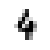

In [4]:
def display_image(n):
    plt.figure(1, figsize=(0.4,0.4))
    img = dataset.images[n]
    plt.imshow(img, cmap=plt.cm.gray_r)
    plt.axis("off")
    plt.show()
    return img

_ = display_image(12)
_ = display_image(100)

et vérifions qu'elles aient toutes bien la même taille

In [5]:
img0shape = dataset.images[0].shape
for img in dataset.images:
    assert img.shape == img0shape

img0shape

(8, 8)

In [6]:
dataset.images[0]

array([[ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.],
       [ 0.,  0., 13., 15., 10., 15.,  5.,  0.],
       [ 0.,  3., 15.,  2.,  0., 11.,  8.,  0.],
       [ 0.,  4., 12.,  0.,  0.,  8.,  8.,  0.],
       [ 0.,  5.,  8.,  0.,  0.,  9.,  8.,  0.],
       [ 0.,  4., 11.,  0.,  1., 12.,  7.,  0.],
       [ 0.,  2., 14.,  5., 10., 12.,  0.,  0.],
       [ 0.,  0.,  6., 13., 10.,  0.,  0.,  0.]])

In [7]:
dataset.data[0]

array([ 0.,  0.,  5., 13.,  9.,  1.,  0.,  0.,  0.,  0., 13., 15., 10.,
       15.,  5.,  0.,  0.,  3., 15.,  2.,  0., 11.,  8.,  0.,  0.,  4.,
       12.,  0.,  0.,  8.,  8.,  0.,  0.,  5.,  8.,  0.,  0.,  9.,  8.,
        0.,  0.,  4., 11.,  0.,  1., 12.,  7.,  0.,  0.,  2., 14.,  5.,
       10., 12.,  0.,  0.,  0.,  0.,  6., 13., 10.,  0.,  0.,  0.])

In [12]:
dataset.target[0]

0

Chaque image est donc de taille $8 \times 8$ pixels, soit $64$ pixels par image. Une image en couleur aurait une troisième dimension représentant la couleur justement. On a donc affaire à des images en nuances de gris ou en noir et blanc. Si les images sont en noir et blanc, on aura seulement deux niveaux de pixel : `0` ou `1`, tandis que des valeurs de pixels différentes renseignent sur les différents niveaux de gris.

In [8]:
min_pixel, max_pixel = 255, 0
for img in dataset.images:
    if np.min(img) < min_pixel:
        min_pixel = np.min(img)
    if np.max(img) > max_pixel:
        max_pixel = np.max(img)
min_pixel, max_pixel

(0.0, 16.0)

On a donc affaire à des images de taille $8 \times 8$ pixels qui ont $16$ niveaux de gris.

Pour conclure cette exploration sommaire, remarquons que les données `data` représentent les images, lorsque toutes les lignes d'une image sont concaténées

In [9]:
for i in range(dataset.data.shape[0]):
    img_flat = dataset.images[i].flatten()
    data = dataset.data[i,:]
    assert list(img_flat) == list(data)

On peut donc soit utiliser directement les images soit utiliser les données déjà éclatées sous forme de lignes de _features_ `dataset.data` et de _target_ `dataset.target`.

## Répartitions des données

Maintenant que l'on a exploré la dimension longitudinale de notre jeu de données, étudions la répartition des différents labels.

In [10]:
counter = Counter(dataset.target)
x = list(counter.keys())
h = list(counter.values())

plt.bar(x,h)
plt.ylabel("Occurences")
plt.title("Occurences des labels")
plt.xticks(list(range(len(labelset))))
plt.show()

In [11]:
import matplotlib.pyplot as plt
from sklearn import datasets

digits = datasets.load_digits()

_, axes = plt.subplots(nrows=1, ncols=4, figsize=(10, 3))
for ax, image, label in zip(axes, digits.images, digits.target):
    ax.set_axis_off()
    ax.imshow(image, cmap=plt.cm.gray_r, interpolation="nearest")
    ax.set_title("Training: %i" % label)

On voit que les données sont extrêmement bien équilibrées, et on n'a pas besoin de regrouper ou sur/sous échantilloner notre jeu de données.

## Stratégie d'apprentissage

Une fois les données explorées, on peut discuter de notre stratégie d'apprentissage.

### Rajouter des _features_ ?

Nous ne possédons pour l'instant que les données des images. La question reste entière sur la nécessité de rajouter des _features_ qui seraient absentes. La stratégie peut consister pour le moment à remiser cette question pour plus tard, et de tout d'abord voir si un algorithme d'apprentissage assez générique ne nous permettrait pas déjà de répondre à toute ou partie du problème.

### Quel type de classifieur ? 

Suivant le type de classifieur que l'on choisira, il faudra faire attention au nombre de classes à prédire : on veut trouver la classe d'une image parmi $K=10$ classes. C'est donc un [problème de classification multiclasses](https://en.wikipedia.org/wiki/Multiclass_classification). 

On peut bien évidemment choisir un classifieur permettant la classification multiclasse, comme 
 - [naive Bayes](https://scikit-learn.org/stable/modules/naive_bayes.html)
 - [decision trees and random forrest](https://scikit-learn.org/stable/modules/tree.html)
 - [multilayer perceptron](https://scikit-learn.org/stable/modules/neural_networks_supervised.html) par exemple

La plupart des classifieurs sont néanmoins binaires, et ne permettent de classer que deux classes. On peut toutefoisles utiliser, et choisir d'utiliser
 - un classifieur par classe : stratégie [one vs. rest](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsRestClassifier.html). Dans ce cas on a $K$ classifieurs répondant oui ou non pour l'appartenance à chacune des $K$ classes : classe `0` oui ou non, classe `1` oui ou non, ..., classe `9` oui ou non.
 - un classifieur par couple de classes : stratégie [one vs. one](https://scikit-learn.org/stable/modules/generated/sklearn.multiclass.OneVsOneClassifier.html). Dans ce cas on a $K(K-1)/2$ classifieurs, chacun distinguant une paire de classes : classe `0` ou classe `1`, classe `0` ou classe `2`, `0` ou `3`, ..., `1` ou `2`, ..., classe `8` ou classe `9`.
 
Voir à ce propos [les tutoriels de scikit-learn](https://scikit-learn.org/stable/modules/multiclass.html).

### Stratégie de validation ?

On va sans doute choisir ici une [validation croisée](https://scikit-learn.org/stable/modules/cross_validation.html#k-fold), assez standard, les données ne sont pas assez déséquilibré entre les classes pour avoir besoin de choisir autre choses, mais on peut bien évidemment tester ! 

### Stratégie de résultats ?

La [plupart des scores sont disponibles sur scikit-learn](https://scikit-learn.org/stable/modules/model_evaluation.html#classification-metrics), on peut donc simplement s'en inspirer et choisir ceux qui semblent le mieux. Attention toutefois, [il ne sont pas tous compatibles avec une classification multilabel](https://scikit-learn.org/stable/modules/model_evaluation.html#from-binary-to-multiclass-and-multilabel). On commencera tout de même par une table de confidence multiclasse, et on explorera le reste des scores si besoin.

### Sur ou sous échantillonage ? 

Puisque les données sont équilibrées, on n'a pas besoin de [sur/sous échantilloner](https://en.wikipedia.org/wiki/Oversampling_and_undersampling_in_data_analysis) notre jeu de données. Mais on peut tout au fois utiliser choisir un nombre toujours égale de données d'entraînement pour chacunes des classes, et réserver les légers désiquilibres pour la phase de test.